In [62]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from qdots_qll.models.game import get_SIC_POVM_4D

import qutip as qt

In [27]:
from qbism import sic_povm

In [145]:
def dag(A):
    return jnp.conjugate(A.T)


def sprepost(A, B):
    return jnp.kron(A, jnp.conjugate(B))


def spre(A):
    return sprepost(A, jnp.identity(2))


def spost(A):
    return sprepost(jnp.identity(2), A)


# def vec(A):
#     return A.flatten()
def vec(A):
    return A.flatten()
    # return A.flatten()[:, jnp.newaxis]

In [99]:
d = 2

In [421]:
povm_arr = jnp.array(sic_povm(d)) * d

In [422]:
?sic_povm

Signature: sic_povm(d)
Docstring: Returns a SIC-POVM of dimension $d$.
File:      ~/miniconda3/envs/jax/lib/python3.11/site-packages/qbism/sics.py
Type:      function

In [423]:
rng = np.random.default_rng(seed=1)

In [424]:
A = rng.random([2, 2]) + 1j * rng.random([2, 2])
B = rng.random([2, 2]) + 1j * rng.random([2, 2])
C = rng.random([2, 2]) + 1j * rng.random([2, 2])

In [425]:
vec(A @ B @ dag(C))

Array([1.1492252-0.04091862j, 1.6888942+0.01579123j,
       0.9675945+0.25725535j, 1.3005437+0.55467325j], dtype=complex64)

In [426]:
jnp.kron(A, jnp.conjugate(C)) @ vec(B)

Array([1.1492252-0.04091859j, 1.6888943+0.01579124j,
       0.9675946+0.25725538j, 1.3005437+0.5546732j ], dtype=complex64)

In [427]:
# def vec(A):
#     return A.flatten()[:, np.newaxis]

In [428]:
rho = qt.rand_dm(2, seed=1).full()

In [429]:
K = (d + 1) * jnp.array([vec(pi) for pi in list(povm_arr)]).T - jnp.array(
    [vec(jnp.identity(2))] * d**2
).T

In [561]:
K_inv = (jnp.array([dag(vec(pi)) for pi in list(povm_arr)])) / d

In [560]:
P_0

Array([0.39433756+0.j, 0.39433756+0.j, 0.10566244+0.j, 0.10566244+0.j],      dtype=complex64)

In [562]:
K_inv @ (K @ (P_0))

Array([0.39433756+0.j, 0.39433756+0.j, 0.10566245+0.j, 0.10566245+0.j],      dtype=complex64)

In [607]:
@jit
def _make_C(H, V):
    return H - 1j / 2 * dag(V) @ V


@jit
def _make_Lambda(H, V):
    return (
        -1j * (spre(H) - spost(H))
        + sprepost(V, dag(V))
        - 0.5 * (spre(dag(V) @ V) + spost(dag(V) @ V))
    )


@jit
def make_L(K, K_inv, H, V):
    return K_inv @ _make_Lambda(H, V) @ K

In [608]:
V = jnp.sqrt(0.1) * qt.sigmap().full() * 1

In [609]:
rho0 = qt.ket2dm(qt.basis(2, 0)).full()

In [610]:
omega = 0.5

H = omega / 2 * qt.sigmax().full()

In [611]:
L = make_L(K, K_inv, H, V)

In [612]:
my_povm = jnp.array(
    (qt.identity(2).full() + jnp.array([qt.sigmaz(), -qt.sigmaz()])) / 2
)

In [613]:
m = jnp.einsum("iljj", jnp.einsum("ijk, lkn ->iljn", my_povm, povm_arr))


E = jnp.einsum("i, m -> im", jnp.einsum("ijj", my_povm), jnp.ones(d**2))

M = (d + 1) * m - E

In [591]:
def rho_to_psic(rho, povm_arr, d):
    return jnp.einsum("ill", jnp.einsum("ijk, kl -> ijl", povm_arr, rho)) / d

In [592]:
def psic_to_rho(p_arr, povm_arr, d):
    K = (d + 1) * povm_arr - jnp.identity(2)
    return jnp.einsum("ijk,i", K, p_arr)

In [593]:
P_0 = rho_to_psic(qt.ket2dm(qt.basis(2, 0)).full(), povm_arr, d)

In [594]:
L = make_L(K, K_inv, H, V)

In [595]:
from jax.scipy.linalg import expm

In [596]:
expm(L) @ P_0

Array([0.4428925 -0.00170973j, 0.31117445+0.00170973j,
       0.05612872-0.00170973j, 0.18784685+0.00170973j], dtype=complex64)

In [597]:
times = jnp.linspace(0, 100, 1000)

In [598]:
P_times = jax.vmap(lambda t: expm(L * t) @ P_0)(times)

/home/antonio/miniconda3/envs/jax/lib/python3.11/site-packages/jax/_src/array.py:377: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


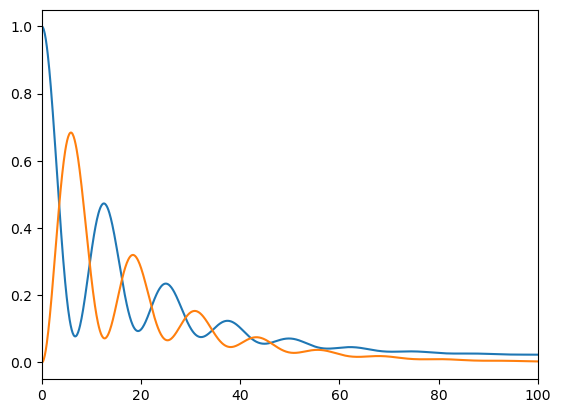

In [603]:
plt.plot(times, jax.vmap(lambda psic: M @ psic)(P_times).T[0])
plt.plot(times, jax.vmap(lambda psic: M @ psic)(P_times).T[1])
plt.xlim(0, 100)
plt.show()

In [614]:
import equinox as eqx

In [645]:
@jit
def sprepost(A, B):
    return jnp.kron(A, jnp.conjugate(B))


class model1(eqx.Module):
    d: int
    md: jnp.array
    sic_povm_arr: jnp.array

    def __init__(self, d):
        self.d = d
        self.md = jnp.ones([d, d])
        self.sic_povm_arr = jnp.array(sic_povm(d)) * d

    @jit
    def example_f(self):
        return jnp.identity(d)

    @jit
    def spre(self, A):
        return sprepost(A, jnp.identity(self.md.shape[0]))

    @jit
    def spost(self, A):
        return sprepost(jnp.identity(self.md.shape[0]), A)

In [ ]:
K = (d + 1) * jnp.array([vec(pi) for pi in list(povm_arr)]).T - jnp.array(
    [vec(jnp.identity(2))] * d**2
).T

In [646]:
model = model1(d=2)

In [647]:
model.sic_povm_arr

Array([[[ 0.7886751 +0.j        ,  0.28867513+0.28867513j],
        [ 0.28867513-0.28867513j,  0.21132487+0.j        ]],

       [[ 0.7886751 +0.j        , -0.28867513-0.28867513j],
        [-0.28867513+0.28867513j,  0.21132487+0.j        ]],

       [[ 0.21132487+0.j        ,  0.28867513-0.28867513j],
        [ 0.28867513+0.28867513j,  0.7886751 +0.j        ]],

       [[ 0.21132487+0.j        , -0.28867513+0.28867513j],
        [-0.28867513-0.28867513j,  0.7886751 +0.j        ]]],      dtype=complex64)

In [644]:
model.spost(A)

Array([[0.5118216 -0.31183144j, 0.9504637 -0.42332646j,
        0.        +0.j        , 0.        +0.j        ],
       [0.14415962-0.8277026j , 0.94864947-0.40919915j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.5118216 -0.31183144j, 0.9504637 -0.42332646j],
       [0.        +0.j        , 0.        +0.j        ,
        0.14415962-0.8277026j , 0.94864947-0.40919915j]], dtype=complex64)